## Example script to run a learnable wavelet scattering network on a subset of the CAMELs data

Simple example script. **Make sure you have run the `wget` command in the README to download the example data file**

We take a small sample of the CAMELs dataset (1k $M_\mathrm{tot}$ maps), and train a "SN" (2 layers of wavelet convolutions, 8 wavelet filters each, and pass the output to a CNN).

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt

## Learnable scattering modules
from learnable_wavelets.models import models_factory, sn_hybrid_models, camels_models
from learnable_wavelets.datasets import camels_dataset 

/mnt/home/cpedersen/miniconda3/envs/wavelet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## training parameters
batch_size  = 32
num_workers = 10    #number of workers to load data
lr_sn       = 0.01  ## Learning rate for scattering layers
lr          = 0.001 ## Learning rate for neural weights
wd          = 0.1   ## weight decay
epochs      = 5

In [3]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory

# architecture parameters
beta1 = 0.5
beta2 = 0.999

fparams    = "../test_data/params_IllustrisTNG.txt" ## Simulation parameter file
#fmaps      = ["/mnt/home/cpedersen/ceph/Data/CAMELS_test/15k_fields/maps_Mtot.npy"]
fmaps      = ["../test_data/maps_Mtot_1k.npy"]   ## Simulated maps, must be a list as we can take multiple maps

fmaps_norm      = [None]
splits          = 1      ## Number of maps taken from each sim (range between 1 and 15, must match the dataset size)
                         ## i.e. splits=1 for 1k maps, splits=15 for 15k maps, or any integer value in between
seed            = 123    ## seed for the test/valid/train split
monopole        = True   ## Keep the monopole of the maps (True) or remove it (False)
rot_flip_in_mem = False  ## Whether rotations and flipings are kept in memory (faster but takes more memory if true)
smoothing       = 0      ## Smooth the maps with a Gaussian filter? 0 for no
arch            = "sn"   ## Which model architecture to use
features        = 12     ## Number of variables to train the model on. This can be 2, 4, 6 or 12, depending on whether
                         ## you want to a) train on both cosmological and IGM parameters and b) also ask the
                         ## network to estimate uncertanties on these parameters

CUDA Available


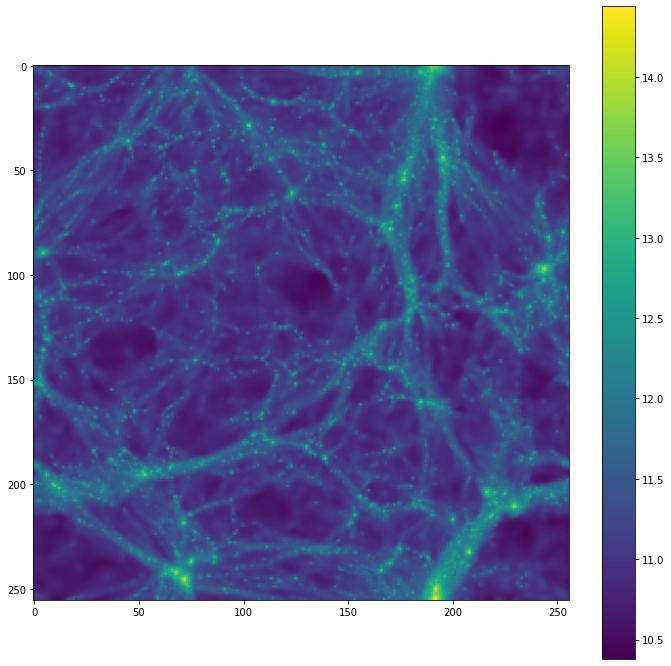

In [4]:
## Load and plot a random map
maps = np.load(fmaps[0])
maps=maps[np.random.randint(len(maps))]

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps))
plt.colorbar()

In [5]:
channels=len(fmaps)
## Set up indices to use for the loss function
if features==2:
    g=[0,1]
if features==4:
    g=[0,1]
    h=[2,3]
elif features==6:
    g=[0,1,2,3,4,5]
elif features==12:
    g=[0,1,2,3,4,5]
    h=[6,7,8,9,10,11]

In [6]:
## Generate torch datasets
print('\nPreparing training set')
train_loader = camels_dataset.create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         num_workers=num_workers, rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# get validation set
print('\nPreparing validation set')
valid_loader = camels_dataset.create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         num_workers=num_workers, rot_flip_in_mem=rot_flip_in_mem,  verbose=True)    

# get test set
print('\nPreparing test set')
test_loader = camels_dataset.create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                        num_workers=num_workers, rot_flip_in_mem=rot_flip_in_mem,  verbose=True)


Preparing training set
Found 1 channels
Reading data...
6.054e+09 < F(all|orig) < 2.176e+15
9.782 < F(all|resc)  < 15.338
-2.696 < F(all|norm) < 8.631

Preparing validation set
Found 1 channels
Reading data...
6.054e+09 < F(all|orig) < 2.176e+15
9.782 < F(all|resc)  < 15.338
-2.696 < F(all|norm) < 8.631

Preparing test set
Found 1 channels
Reading data...
6.054e+09 < F(all|orig) < 2.176e+15
9.782 < F(all|resc)  < 15.338
-2.696 < F(all|norm) < 8.631


In [7]:
## Create the wavelet scattering layers
scatteringBase = models_factory.baseModelFactory(
                                architecture='scattering',
                                J=2,
                                N=256,
                                M=256,
                                channels=channels,
                                max_order=2,
                                initialization="Random",
                                seed=234,
                                learnable=True,
                                lr_orientation=lr_sn,
                                lr_scattering=lr_sn,
                                skip=True,
                                split_filters=True,
                                filter_video=False,
                                subsample=4,
                                device=device,
                                use_cuda=use_cuda,
                                plot=False
                                )

## Now create a network to follow the scattering layers
## can be MLP, linear, or cnn at the moment
## (as in https://github.com/bentherien/ParametricScatteringNetworks/ )
top = models_factory.topModelFactory(
    base=scatteringBase,
    architecture="cnn", ## Can be "cnn", "linear_layer", or "mlp"
    num_classes=features,
    width=3,                    ## Number of hidden layers (only used for cnn and mlp)
    average=True,
    use_cuda=True
)

## Merge scattering and neural layers into a single torch module
hybridModel = sn_hybrid_models.sn_HybridModel(scatteringBase=scatteringBase, top=top, use_cuda=use_cuda)
model=hybridModel
model.to(device=device) ## Put model on the appropriate device
print("Scattering + neural model initialised")

/mnt/home/cpedersen/miniconda3/envs/wavelet/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811757271/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Scattering + neural model initialised


In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

In [9]:
## Train and valid loops
start = time.time()
for epoch in range(epochs):
    # train
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        if features==4 or features==12:
            e_NN = p[:,h]         #posterior std
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            train_loss2 += loss2*bs
        else:
            loss = torch.mean(torch.log(loss1))
        train_loss1 += loss1*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = torch.log(train_loss1/points) 
    if features==4 or features==12:
        train_loss+=torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            if features==4 or features==12:    
                e_NN  = p[:,h]         #posterior std
                loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
                valid_loss2 += loss2*bs
            valid_loss1 += loss1*bs
            points     += bs


    valid_loss = torch.log(valid_loss1/points) 
    if features==4 or features==12:
        valid_loss+=torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    scheduler.step(valid_loss)

    # verbose
    print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')
    print("")

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

## Model performance metrics on test set
num_maps=test_loader.dataset.size
## Now loop over test set and print accuracy
# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

000 -2.945e+00 -5.357e+00 
001 -6.617e+00 -5.792e+00 
002 -7.089e+00 -4.550e+00 
003 -7.324e+00 -7.297e+00 
004 -7.587e+00 -2.194e+00 
Time take (h): 0.0121


Test loss = -3.015e+00

Error Omega_m = 53.296
Error sigma_8 = 20.410
Error A_SN1   = 185.094
Error A_AGN1  = 207.649
Error A_SN2   = 57.628
Error A_AGN2  = 60.323

Bayesian error Omega_m = 4.614
Bayesian error sigma_8 = 0.720
Bayesian error A_SN1   = 28.002
Bayesian error A_AGN1  = 168.198
Bayesian error A_SN2   = 53.527
Bayesian error A_AGN2  = 176.324



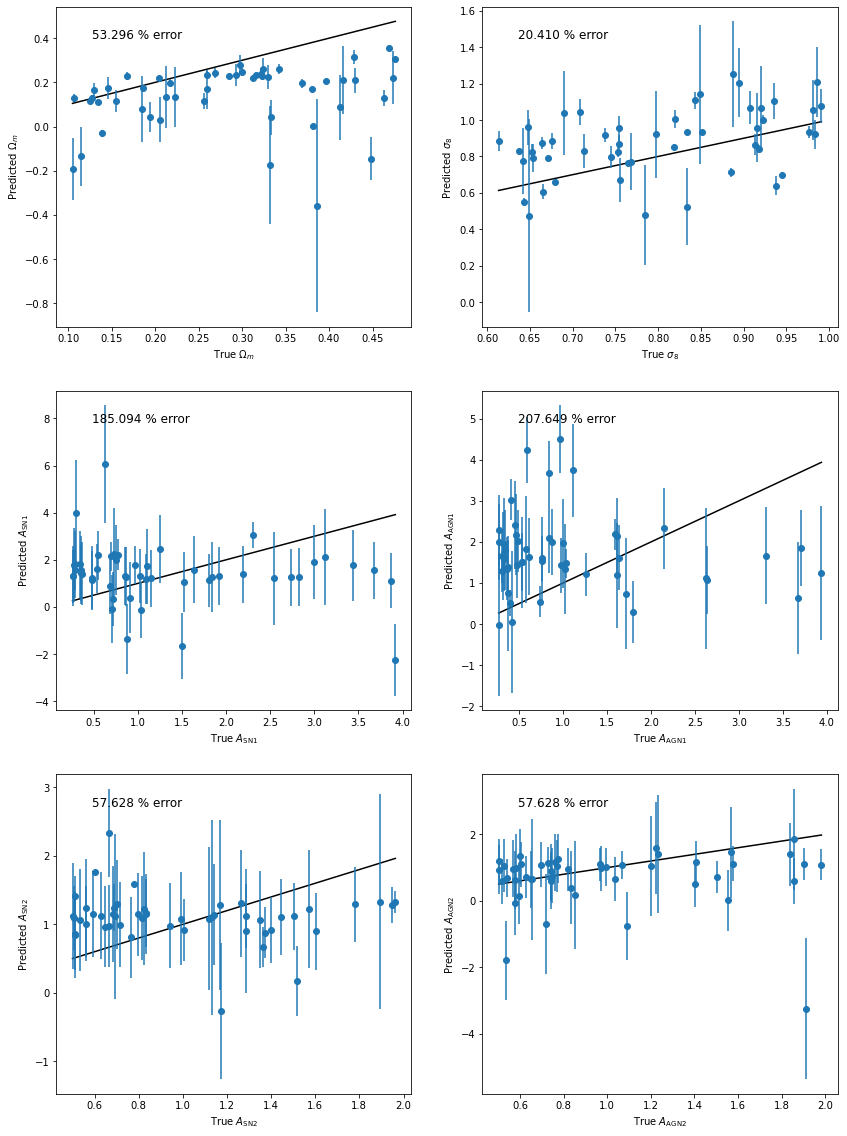

In [10]:
# get test loss
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]         #batch size
        x     = x.to(device)       #send data to device
        y     = y.to(device)[:,g]  #send data to device
        p     = model(x)           #prediction for mean and variance
        y_NN  = p[:,g]             #prediction for mean
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        if features==4 or features==12:
            e_NN  = p[:,h]         #posterior std
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            test_loss2 += loss2*bs
        test_loss1 += loss1*bs
        test_loss = torch.log(test_loss1/points)
        if features==4 or features==12:
            test_loss+=torch.log(test_loss2/points)
        test_loss = torch.mean(test_loss).item()

#e_NN  = p[:,6:]       #prediction for error
#loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
#loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
#test_loss1 += loss1*bs
#test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy() 
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        if features==4 or features==12:
            errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

# de-normalize
## I guess these are the hardcoded parameter limits
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])

## Drop feedback parameters if they aren't included
minimum=minimum[g]
maximum=maximum[g]
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum


test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
print('Error Omega_m = %.3f'%test_error[0])
print('Error sigma_8 = %.3f'%test_error[1])
if features>4:
    print('Error A_SN1   = %.3f'%test_error[2])
    print('Error A_AGN1  = %.3f'%test_error[3])
    print('Error A_SN2   = %.3f'%test_error[4])
    print('Error A_AGN2  = %.3f\n'%test_error[5])
if features==4:
    errors_NN   = errors_NN*(maximum - minimum)
    mean_error = 100*(np.absolute(np.mean(errors_NN/params_NN, axis=0)))
    print('Bayesian error Omega_m = %.3f'%mean_error[0])
    print('Bayesian error sigma_8 = %.3f'%mean_error[1])

elif features==12:
    errors_NN   = errors_NN*(maximum - minimum)
    mean_error = 100*(np.absolute(np.mean(errors_NN/params_NN, axis=0)))
    print('Bayesian error Omega_m = %.3f'%mean_error[0])
    print('Bayesian error sigma_8 = %.3f'%mean_error[1])
    print('Bayesian error A_SN1   = %.3f'%mean_error[2])
    print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
    print('Bayesian error A_SN2   = %.3f'%mean_error[4])
    print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])


if features<5:
    f, axarr = plt.subplots(1, 2, figsize=(9,6))
    axarr[0].plot(np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),np.linspace(min(params_true[:,0]),max(params_true[:,0]),100),color="black")
    axarr[1].plot(np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),np.linspace(min(params_true[:,1]),max(params_true[:,1]),100),color="black")
    if features==4:
        axarr[0].errorbar(params_true[:,0],params_NN[:,0],errors_NN[:,0],marker="o",ls="none")
        axarr[1].errorbar(params_true[:,1],params_NN[:,1],errors_NN[:,1],marker="o",ls="none")
    else:
        axarr[0].plot(params_true[:,0],params_NN[:,0],marker="o",ls="none")
        axarr[1].plot(params_true[:,1],params_NN[:,1],marker="o",ls="none")

    axarr[0].set_xlabel(r"True $\Omega_m$")
    axarr[0].set_ylabel(r"Predicted $\Omega_m$")
    axarr[0].text(0.1,0.9,"%.3f %% error" % test_error[0],fontsize=12,transform=axarr[0].transAxes)

    axarr[1].set_xlabel(r"True $\sigma_8$")
    axarr[1].set_ylabel(r"Predicted $\sigma_8$")
    axarr[1].text(0.1,0.9,"%.3f %% error" % test_error[1],fontsize=12,transform=axarr[1].transAxes)


if features>4:
    f, axarr = plt.subplots(3, 2, figsize=(14,20))
    for aa in range(0,6,2):
        axarr[aa//2][0].plot(np.linspace(min(params_true[:,aa]),max(params_true[:,aa]),100),np.linspace(min(params_true[:,aa]),max(params_true[:,aa]),100),color="black")
        axarr[aa//2][1].plot(np.linspace(min(params_true[:,aa+1]),max(params_true[:,aa+1]),100),np.linspace(min(params_true[:,aa+1]),max(params_true[:,aa+1]),100),color="black")
        if features==12:
            axarr[aa//2][0].errorbar(params_true[:,aa],params_NN[:,aa],errors_NN[:,aa],marker="o",ls="none")
            axarr[aa//2][1].errorbar(params_true[:,aa+1],params_NN[:,aa+1],errors_NN[:,aa+1],marker="o",ls="none")
        else:
            axarr[aa//2][0].plot(params_true[:,aa],params_NN[:,aa],marker="o",ls="none")
            axarr[aa//2][1].plot(params_true[:,aa+1],params_NN[:,aa+1],marker="o",ls="none")

    axarr[0][0].set_xlabel(r"True $\Omega_m$")
    axarr[0][0].set_ylabel(r"Predicted $\Omega_m$")
    axarr[0][0].text(0.1,0.9,"%.3f %% error" % test_error[0],fontsize=12,transform=axarr[0][0].transAxes)

    axarr[0][1].set_xlabel(r"True $\sigma_8$")
    axarr[0][1].set_ylabel(r"Predicted $\sigma_8$")
    axarr[0][1].text(0.1,0.9,"%.3f %% error" % test_error[1],fontsize=12,transform=axarr[0][1].transAxes)

    axarr[1][0].set_xlabel(r"True $A_\mathrm{SN1}$")
    axarr[1][0].set_ylabel(r"Predicted $A_\mathrm{SN1}$")
    axarr[1][0].text(0.1,0.9,"%.3f %% error" % test_error[2],fontsize=12,transform=axarr[1][0].transAxes)

    axarr[1][1].set_xlabel(r"True $A_\mathrm{AGN1}$")
    axarr[1][1].set_ylabel(r"Predicted $A_\mathrm{AGN1}$")
    axarr[1][1].text(0.1,0.9,"%.3f %% error" % test_error[3],fontsize=12,transform=axarr[1][1].transAxes)

    axarr[2][0].set_xlabel(r"True $A_\mathrm{SN2}$")
    axarr[2][0].set_ylabel(r"Predicted $A_\mathrm{SN2}$")
    axarr[2][0].text(0.1,0.9,"%.3f %% error" % test_error[4],fontsize=12,transform=axarr[2][0].transAxes)

    axarr[2][1].set_xlabel(r"True $A_\mathrm{AGN2}$")
    axarr[2][1].set_ylabel(r"Predicted $A_\mathrm{AGN2}$")
    axarr[2][1].text(0.1,0.9,"%.3f %% error" % test_error[4],fontsize=12,transform=axarr[2][1].transAxes)